In [1]:
%pip install seaborn
import os
import cv2
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [2]:

# --------------------------
# Base paths
# --------------------------
BASE_DIR = r"C:\Users\vaide\MITResearchWork\G1\G1"
INFECTED = "GL20241212195023"
UNINFECTED = "GL20241212193213"

PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# --------------------------
# Spreadsheet values
# --------------------------
spreadsheet_values = {
    UNINFECTED: [
        {"MouseID": "1X", "Uterus total volume": 118700, "Uterus cyst total volume": 14270,
         "Cysts/Uterus Percent Volume": 12.02, "ParaAo LN": 4.04},
        {"MouseID": "1R", "Uterus total volume": 148300, "Uterus cyst total volume": 23830,
         "Cysts/Uterus Percent Volume": 16.07, "ParaAo LN": 4.94},
        {"MouseID": "1L", "Uterus total volume": 82470, "Uterus cyst total volume": 6604,
         "Cysts/Uterus Percent Volume": 8.01, "ParaAo LN": 2.06},
        {"MouseID": "1RL", "Uterus total volume": 116100, "Uterus cyst total volume": 35840,
         "Cysts/Uterus Percent Volume": 30.87, "ParaAo LN": 2.93},
    ],
    INFECTED: [
        {"MouseID": "2X", "Uterus total volume": 122.2, "Uterus cyst total volume": 23.25,
         "Cysts/Uterus Percent Volume": 19.03, "ParaAo LN": 8.48},
        {"MouseID": "2R", "Uterus total volume": 159.4, "Uterus cyst total volume": 40.33,
         "Cysts/Uterus Percent Volume": 25.30, "ParaAo LN": 12.83},
        {"MouseID": "2L", "Uterus total volume": 139.4, "Uterus cyst total volume": 24.91,
         "Cysts/Uterus Percent Volume": 17.87, "ParaAo LN": 8.86},
        {"MouseID": "2RR", "Uterus total volume": 193.9, "Uterus cyst total volume": 64.75,
         "Cysts/Uterus Percent Volume": 33.39, "ParaAo LN": 8.00},
        {"MouseID": "2RL", "Uterus total volume": 226, "Uterus cyst total volume": 67.43,
         "Cysts/Uterus Percent Volume": 29.84, "ParaAo LN": 13.93},
    ]
}


In [3]:

# --------------------------
# Measure flux with masks
# --------------------------
def measure_flux_from_mask(lum_path, mask_path, n_expected):
    lum = cv2.imread(lum_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path)

    if lum is None:
        raise FileNotFoundError(f"Could not load luminescent image: {lum_path}")
    if mask_img is None:
        raise FileNotFoundError(f"Could not load mask image: {mask_path}")

    # Detect blue outlines (your drawn boxes)
    lower_blue = np.array([100, 0, 0])   # BGR
    upper_blue = np.array([255, 80, 80])
    mask = cv2.inRange(mask_img, lower_blue, upper_blue)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    fluxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = lum[y:y+h, x:x+w]
        fluxes.append(np.sum(roi))

    fluxes = sorted(fluxes, reverse=True)
    if len(fluxes) < n_expected:
        print(f"[Warning] Found {len(fluxes)} boxes, expected {n_expected}")
    return fluxes[:n_expected]



✅ Results DataFrame:
  MouseID  Uterus total volume  Uterus cyst total volume  \
0      1X             118700.0                  14270.00   
1      1R             148300.0                  23830.00   
2      1L              82470.0                   6604.00   
3     1RL             116100.0                  35840.00   
4      2X                122.2                     23.25   
5      2R                159.4                     40.33   
6      2L                139.4                     24.91   
7     2RR                193.9                     64.75   
8     2RL                226.0                     67.43   

   Cysts/Uterus Percent Volume  ParaAo LN  Flux       Group  
0                        12.02       4.04    41  Uninfected  
1                        16.07       4.94    13  Uninfected  
2                         8.01       2.06     9  Uninfected  
3                        30.87       2.93     9  Uninfected  
4                        19.03       8.48   252    Infected  
5    

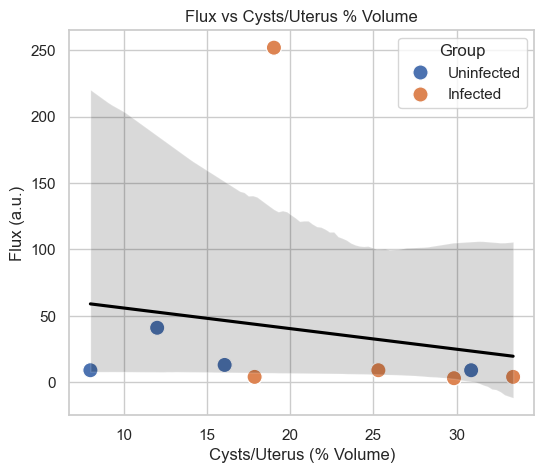

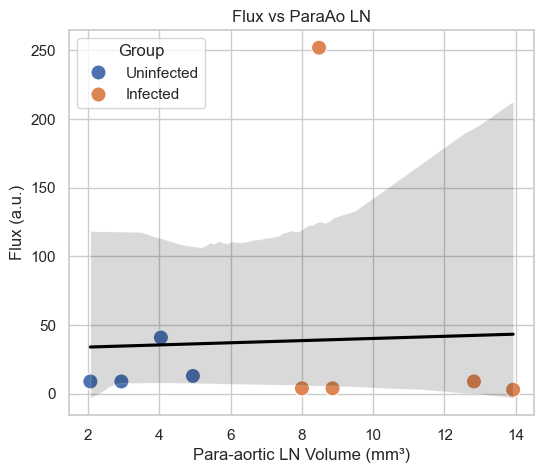

In [4]:
# --------------------------
# Main
# --------------------------
if __name__ == "__main__":
    results = []

    for folder, mice in [(UNINFECTED, spreadsheet_values[UNINFECTED]),
                         (INFECTED, spreadsheet_values[INFECTED])]:

        lum_path = os.path.join(BASE_DIR, folder, "luminescent.TIF")
        mask_path = os.path.join(BASE_DIR, folder, "image1.PNG")

        fluxes = measure_flux_from_mask(lum_path, mask_path, len(mice))

        for mouse, flux in zip(mice, fluxes):
            row = mouse.copy()
            row["Flux"] = flux
            row["Group"] = "Infected" if folder == INFECTED else "Uninfected"
            results.append(row)

    df = pd.DataFrame(results)
    print("\n✅ Results DataFrame:")
    print(df)

    # --------------------------
    # Plots (display only)
    # --------------------------
    sns.set(style="whitegrid")

    # Flux vs Cysts/Uterus Percent Volume
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df, x="Cysts/Uterus Percent Volume", y="Flux", hue="Group", s=120)
    sns.regplot(data=df, x="Cysts/Uterus Percent Volume", y="Flux", scatter=False, color="black")
    plt.title("Flux vs Cysts/Uterus % Volume")
    plt.xlabel("Cysts/Uterus (% Volume)")
    plt.ylabel("Flux (a.u.)")
    plt.legend(title="Group")
    plt.show()

    # Flux vs ParaAo LN
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df, x="ParaAo LN", y="Flux", hue="Group", s=120)
    sns.regplot(data=df, x="ParaAo LN", y="Flux", scatter=False, color="black")
    plt.title("Flux vs ParaAo LN")
    plt.xlabel("Para-aortic LN Volume (mm³)")
    plt.ylabel("Flux (a.u.)")
    plt.legend(title="Group")
    plt.show()
